In [20]:

# Paste your full Google Drive shareable link here
GOOGLE_DRIVE_LINK = "https://drive.google.com/file/d/1KLnVKougQauelIE9_83vr9uiZreArfoJ/view?usp=drive_link"

# Optional: change output filename
OUTPUT_FILENAME = "survey_responses.csv"

# -----------------------------
# No changes needed below
# -----------------------------

import os
import re
import subprocess

# Create data directory (Colab convention)
DATA_DIR = "/content/data"
os.makedirs(DATA_DIR, exist_ok=True)
CSV_LOCAL_PATH = os.path.join(DATA_DIR, OUTPUT_FILENAME)

# Extract file ID from the link
def extract_drive_id(url):
    # Match file ID in formats like:
    # - https://drive.google.com/file/d/FILE_ID/view
    # - https://drive.google.com/open?id=FILE_ID
    # - https://drive.google.com/drive/folders/... (won't match — correct)
    match = re.search(r'[/]d[/]([^/]+)', url)
    if match:
        return match.group(1)
    match = re.search(r'[?&]id=([^&]+)', url)
    if match:
        return match.group(1)
    raise ValueError("Could not extract file ID from the Google Drive link. Please use a standard 'Shareable link'.")

DRIVE_FILE_ID = extract_drive_id(GOOGLE_DRIVE_LINK)

# Install gdown (quietly)
print("Installing gdown...")
subprocess.run([sys.executable, "-m", "pip", "install", "-q", "gdown"], check=True)

# Download
print(f"Downloading file (ID: {DRIVE_FILE_ID}) from Google Drive...")
import gdown
gdown.download(id=DRIVE_FILE_ID, output=CSV_LOCAL_PATH, quiet=False)

# Verify
if os.path.exists(CSV_LOCAL_PATH):
    print(f"✅ Successfully downloaded to: {CSV_LOCAL_PATH}")
else:
    raise FileNotFoundError("❌ Download failed. Check the link and permissions.")


Installing gdown...


Downloading...
From: https://drive.google.com/uc?id=1KLnVKougQauelIE9_83vr9uiZreArfoJ
To: /content/data/survey_responses.csv
100%|██████████| 5.87k/5.87k [00:00<00:00, 20.3MB/s]

✅ Successfully downloaded to: /content/data/survey_responses.csv


In [21]:
# Standard imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import variance_inflation_factor
from pathlib import Path
import warnings
warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', 200)

print("File exists:", Path(CSV_LOCAL_PATH).exists())
df_raw = pd.read_csv(CSV_LOCAL_PATH)
print("Raw dataset shape:", df_raw.shape)
display(df_raw.head())
print("\nColumns:")
for c in df_raw.columns:
    print(" -", c)


File exists: True
Raw dataset shape: (82, 15)


,Timestamp,You're Currently On,Gender,Age,Current CGPA,How many hours do you spend on studying per week?,How many credits are you currently enrolled in?,Do you participate in extracurricular activities?,"If yes, how many hours per week?",Do you have a part-time job? (Including Tuition),"If yes, how many hours per week?.1",How would you rate your stress level this semester?,How would you rate your anxiety level?,How many hours of sleep do you get per night?(On Average),How would you rate your overall sleep quality?
0,8/21/2025 23:02:04,1st Year,Female,20,NaN,7,NaN,Yes,NaN,Yes,8.0,5,5.0,6.0,6
1,8/21/2025 23:11:48,4th Year,Male,24,2.88,20,20.0,No,NaN,Yes,36.0,4,4.0,5.0,6
2,8/21/2025 23:20:27,2nd Year,Male,23,3.40,10,60.0,Yes,10.0,No,10.0,1,1.0,10.0,1
3,8/21/2025 23:28:43,3rd Year,Male,22,3.90,5,13.0,Yes,8.0,No,NaN,5,4.0,4.0,7
4,8/21/2025 23:34:01,2nd Year,Male,22,3.00,14,13.0,No,NaN,No,NaN,3,3.0,6.0,5



Columns:
 - Timestamp
 - You're Currently On
 - Gender
 - Age
 - Current CGPA
 - How many hours do you spend on studying per week?
 - How many credits are you currently enrolled in?
 - Do you participate in extracurricular activities?
 - If yes, how many hours per week?
 - Do you have a part-time job? (Including Tuition)
 - If yes, how many hours per week?.1
 - How would you rate your stress level this semester?
 - How would you rate your anxiety level?
 - How many hours of sleep do you get per night?(On Average)
 - How would you rate your overall sleep quality?


In [22]:
# Cleaning function - maps common Google Form labels to standard names and coerces types
def clean_transform(df):
    df = df.copy()
    rename_map = {}
    for col in df.columns:
        low = col.lower()
        if 'year' in low and 'study' in low:
            rename_map[col] = 'year_of_study'
        elif low.strip().startswith('gender'):
            rename_map[col] = 'gender'
        elif 'age' == low.strip() or ('age' in low and 'your' in low):
            rename_map[col] = 'age'
        elif 'cgpa' in low:
            rename_map[col] = 'cgpa'
        elif 'study' in low and 'week' in low:
            rename_map[col] = 'study_hours_per_week'
        elif ('course' in low and ('enroll' in low or 'credit' in low or 'current' in low)):
            rename_map[col] = 'courses_enrolled'
        elif 'extracurricular' in low or ('extra' in low and 'activity' in low):
            if 'hours' in low:
                rename_map[col] = 'extra_hours_per_week'
            else:
                rename_map[col] = 'extracurricular'
        elif 'job' in low and ('part' in low or 'have' in low or 'tuition' in low):
            rename_map[col] = 'job'
        elif 'job' in low and 'hours' in low:
            rename_map[col] = 'job_hours_per_week'
        elif 'stress' in low and 'level' in low or low.strip().startswith('stress'):
            rename_map[col] = 'stress_1to5'
        elif 'anxiety' in low:
            rename_map[col] = 'anxiety_1to5'
        elif 'how many hours of sleep' in low or ('sleep' in low and 'hours' in low):
            rename_map[col] = 'sleep_hours'
        elif 'sleep' in low and 'quality' in low:
            rename_map[col] = 'sleep_quality_1to10'
        elif 'timestamp' in low or 'time' in low:
            rename_map[col] = 'timestamp'
    df = df.rename(columns=rename_map)

    # Coerce numeric columns
    numeric_cols = ['age','cgpa','study_hours_per_week','courses_enrolled','extra_hours_per_week',
                    'job_hours_per_week','sleep_hours','sleep_quality_1to10','stress_1to5','anxiety_1to5']
    for c in numeric_cols:
        if c in df.columns:
            df[c] = pd.to_numeric(df[c], errors='coerce')

    # Standardize Yes/No fields
    if 'extracurricular' in df.columns:
        df['extracurricular'] = df['extracurricular'].astype(str).str.strip().str.title()
        df.loc[df['extracurricular'].isin(['Yes','Y','True','1']), 'extracurricular'] = 'Yes'
        df.loc[df['extracurricular'].isin(['No','N','False','0']), 'extracurricular'] = 'No'
        df['extracurricular_bin'] = (df['extracurricular']=='Yes').astype(int)
    else:
        df['extracurricular_bin'] = 0

    if 'job' in df.columns:
        df['job'] = df['job'].astype(str).str.strip().str.title()
        df.loc[df['job'].isin(['Yes','Y','True','1']), 'job'] = 'Yes'
        df.loc[df['job'].isin(['No','N','False','0']), 'job'] = 'No'
        df['job_bin'] = (df['job']=='Yes').astype(int)
    else:
        df['job_bin'] = 0

    # Year fix
    if 'year_of_study' in df.columns:
        df['year_of_study'] = pd.to_numeric(df['year_of_study'], errors='coerce').astype('Int64')

    # Fill extra hours / job hours with 0 for No responses
    if 'extra_hours_per_week' in df.columns and 'extracurricular' in df.columns:
        df.loc[df['extracurricular']=='No','extra_hours_per_week'] = df.loc[df['extracurricular']=='No','extra_hours_per_week'].fillna(0)
    if 'job_hours_per_week' in df.columns and 'job' in df.columns:
        df.loc[df['job']=='No','job_hours_per_week'] = df.loc[df['job']=='No','job_hours_per_week'].fillna(0)

    # High stress indicator
    if 'stress_1to5' in df.columns:
        df['high_stress'] = (df['stress_1to5'] >= 4).astype(int)

    # Drop columns fully NA
    df = df.loc[:, df.notna().any()]

    # Reset index
    df = df.reset_index(drop=True)
    return df

# Apply cleaning
df = pd.read_csv(CSV_LOCAL_PATH)
cleaned = clean_transform(df)
CLEANED_PATH = os.path.join(DATA_DIR, "cleaned_survey_data.csv")
cleaned.to_csv(CLEANED_PATH, index=False)
print("Cleaned shape:", cleaned.shape)
display(cleaned.head())


Cleaned shape: (82, 18)


,timestamp,You're Currently On,gender,age,cgpa,study_hours_per_week,How many credits are you currently enrolled in?,extracurricular,"If yes, how many hours per week?",job,"If yes, how many hours per week?.1",stress_1to5,anxiety_1to5,sleep_hours,sleep_quality_1to10,extracurricular_bin,job_bin,high_stress
0,8/21/2025 23:02:04,1st Year,Female,20,NaN,7,NaN,Yes,NaN,Yes,8.0,5,5.0,6.0,6,1,1,1
1,8/21/2025 23:11:48,4th Year,Male,24,2.88,20,20.0,No,NaN,Yes,36.0,4,4.0,5.0,6,0,1,1
2,8/21/2025 23:20:27,2nd Year,Male,23,3.40,10,60.0,Yes,10.0,No,10.0,1,1.0,10.0,1,1,0,0
3,8/21/2025 23:28:43,3rd Year,Male,22,3.90,5,13.0,Yes,8.0,No,NaN,5,4.0,4.0,7,1,0,1
4,8/21/2025 23:34:01,2nd Year,Male,22,3.00,14,13.0,No,NaN,No,NaN,3,3.0,6.0,5,0,0,0


In [23]:
print("Standardized columns:")
for c in cleaned.columns:
    print(" -", c)

# If something was mis-mapped, rename manually here before proceeding, e.g.:
# cleaned = cleaned.rename(columns={'Old Name':'study_hours_per_week'})
# cleaned.to_csv(CLEANED_PATH, index=False)


Standardized columns:
 - timestamp
 - You're Currently On
 - gender
 - age
 - cgpa
 - study_hours_per_week
 - How many credits are you currently enrolled in?
 - extracurricular
 - If yes, how many hours per week?
 - job
 - If yes, how many hours per week?.1
 - stress_1to5
 - anxiety_1to5
 - sleep_hours
 - sleep_quality_1to10
 - extracurricular_bin
 - job_bin
 - high_stress


Numeric columns used: ['age', 'cgpa', 'study_hours_per_week', 'sleep_hours', 'sleep_quality_1to10', 'stress_1to5', 'anxiety_1to5']


,count,mean,std,min,25%,50%,75%,max
age,82.0,22.731707,1.133647,19.00,22.00,23.00,23.00,25.0
cgpa,73.0,3.258904,0.493695,1.48,3.00,3.29,3.67,4.0
study_hours_per_week,82.0,11.780488,12.237389,1.00,4.25,7.00,14.75,80.0
sleep_hours,79.0,5.759494,1.576796,2.00,5.00,6.00,7.00,10.0
sleep_quality_1to10,82.0,4.670732,2.474836,1.00,3.00,5.00,6.00,10.0
stress_1to5,82.0,3.865854,1.062982,1.00,3.00,4.00,5.00,5.0
anxiety_1to5,81.0,3.740741,1.180866,1.00,3.00,4.00,5.00,5.0


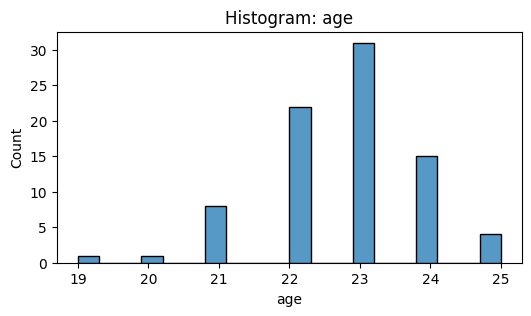

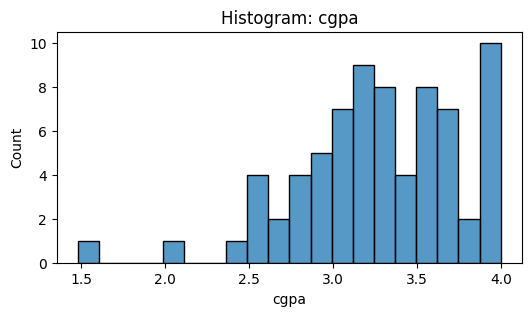

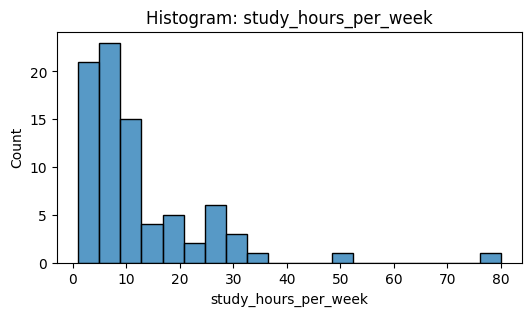

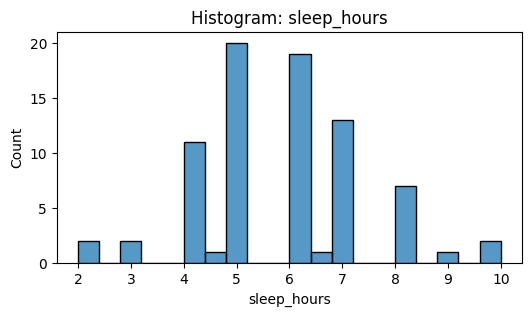

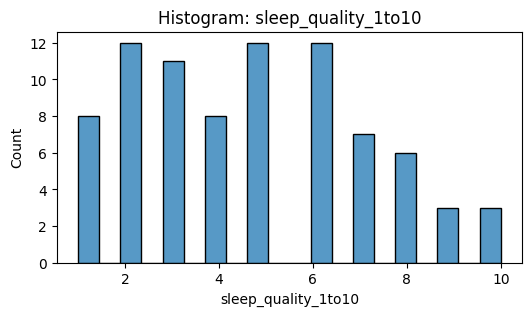

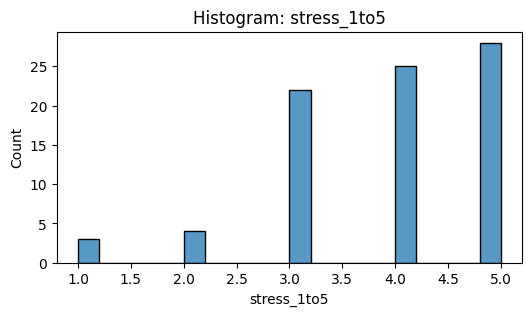

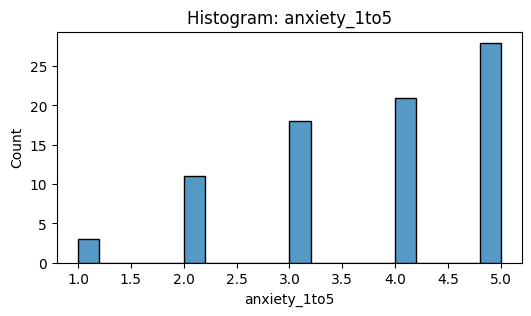

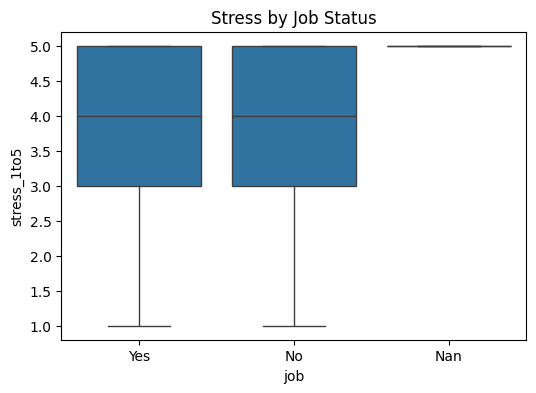

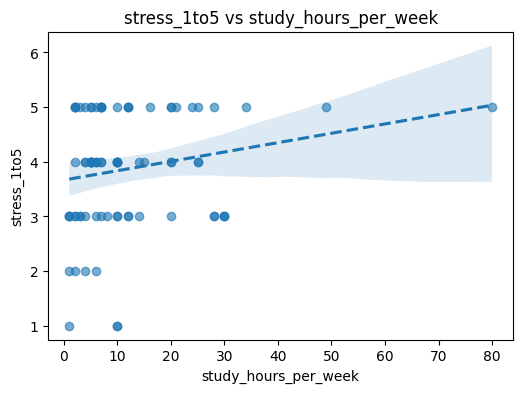

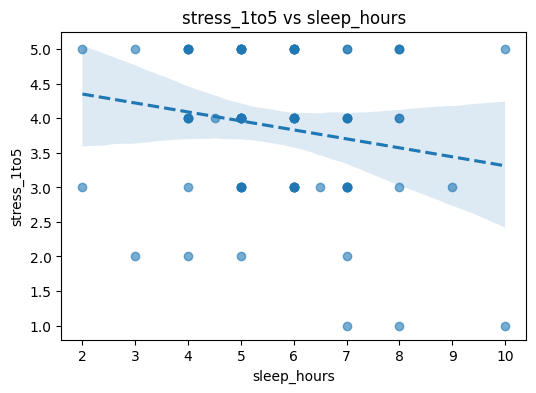

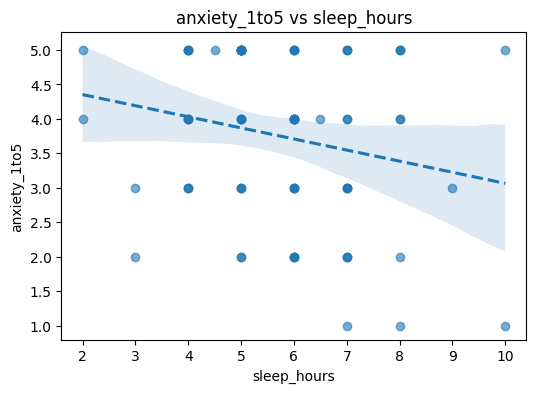

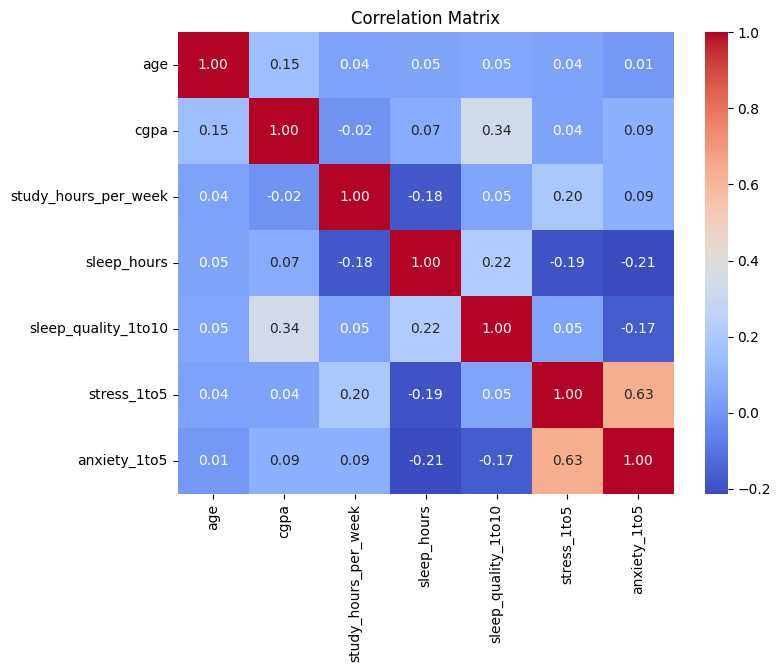

In [24]:
# EDA
numeric_cols = [c for c in ['age','cgpa','study_hours_per_week','courses_enrolled','extra_hours_per_week',
                            'job_hours_per_week','sleep_hours','sleep_quality_1to10','stress_1to5','anxiety_1to5'] if c in cleaned.columns]

print("Numeric columns used:", numeric_cols)
display(cleaned[numeric_cols].describe().T)

# Histograms
for col in numeric_cols:
    plt.figure(figsize=(6,3))
    sns.histplot(cleaned[col].dropna(), bins=20, kde=False)
    plt.title(f"Histogram: {col}")
    plt.show()

# Boxplots for group comparisons
if 'job' in cleaned.columns and 'stress_1to5' in cleaned.columns:
    plt.figure(figsize=(6,4))
    sns.boxplot(data=cleaned, x='job', y='stress_1to5')
    plt.title("Stress by Job Status")
    plt.show()

if 'year_of_study' in cleaned.columns and 'anxiety_1to5' in cleaned.columns:
    plt.figure(figsize=(6,4))
    sns.boxplot(data=cleaned, x='year_of_study', y='anxiety_1to5')
    plt.title("Anxiety by Year of Study")
    plt.show()

# Scatter plots + fit lines
pairs = [('study_hours_per_week','stress_1to5'), ('sleep_hours','stress_1to5'), ('sleep_hours','anxiety_1to5')]
for xcol,ycol in pairs:
    if xcol in cleaned.columns and ycol in cleaned.columns:
        valid = cleaned[[xcol,ycol]].dropna()
        if len(valid) >= 2:
            plt.figure(figsize=(6,4))
            sns.regplot(x=xcol, y=ycol, data=valid, scatter_kws={'alpha':0.6}, line_kws={'linestyle':'--'})
            plt.title(f"{ycol} vs {xcol}")
            plt.show()

# Correlation matrix heatmap
if len(numeric_cols) >= 2:
    corr = cleaned[numeric_cols].corr()
    plt.figure(figsize=(8,6))
    sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", square=False)
    plt.title("Correlation Matrix")
    plt.show()


In [25]:
alpha = 0.05
print("Alpha =", alpha)

# 1) t-test: stress by job status
if 'job' in cleaned.columns and 'stress_1to5' in cleaned.columns:
    grp_yes = cleaned.loc[cleaned['job']=='Yes', 'stress_1to5'].dropna()
    grp_no  = cleaned.loc[cleaned['job']=='No', 'stress_1to5'].dropna()
    print("\nT-test: stress by job status (Yes vs No)")
    if len(grp_yes) > 1 and len(grp_no) > 1:
        t_stat, p_val = stats.ttest_ind(grp_yes, grp_no, equal_var=False)
        print(f" t = {t_stat:.3f}, p = {p_val:.4f}")
        print(" Result:", "Significant difference" if p_val < alpha else "No significant difference")
    else:
        print(" Insufficient data for t-test")

# 2) ANOVA: anxiety across year_of_study
if 'year_of_study' in cleaned.columns and 'anxiety_1to5' in cleaned.columns:
    groups = [cleaned.loc[cleaned['year_of_study']==k, 'anxiety_1to5'].dropna() for k in sorted(cleaned['year_of_study'].dropna().unique())]
    print("\nANOVA: anxiety by year_of_study")
    if len(groups) >= 2 and all(len(g) > 1 for g in groups):
        F_stat, p_val = stats.f_oneway(*groups)
        print(f" F = {F_stat:.3f}, p = {p_val:.4f}")
        print(" Result:", "At least one mean differs" if p_val < alpha else "No evidence of difference")
    else:
        print(" Insufficient groups for ANOVA")

# 3) Pearson correlation: study hours vs stress
if 'study_hours_per_week' in cleaned.columns and 'stress_1to5' in cleaned.columns:
    valid = cleaned[['study_hours_per_week','stress_1to5']].dropna()
    print("\nPearson correlation: study_hours_per_week vs stress_1to5")
    if len(valid) >= 3:
        r, p = stats.pearsonr(valid['study_hours_per_week'], valid['stress_1to5'])
        print(f" r = {r:.3f}, p = {p:.4f}")
        print(" Result:", "Significant correlation" if p < alpha else "No significant correlation")
    else:
        print(" Insufficient data for Pearson")

# 4) Proportion test: high stress (>=4) by job status
if 'job' in cleaned.columns and 'high_stress' in cleaned.columns:
    grp1 = cleaned.loc[cleaned['job']=='Yes','high_stress'].dropna().astype(int)
    grp2 = cleaned.loc[cleaned['job']=='No','high_stress'].dropna().astype(int)
    print("\nProportion z-test: high_stress by job status")
    if len(grp1) > 0 and len(grp2) > 0:
        try:
            from statsmodels.stats.proportion import proportions_ztest
            z_stat, p_val = proportions_ztest([grp1.sum(), grp2.sum()], [len(grp1), len(grp2)])
            print(f" z = {z_stat:.3f}, p = {p_val:.4f}")
            print(" Result:", "Proportions differ" if p_val < alpha else "No evidence of difference")
        except Exception:
            # manual approx
            p_pool = (grp1.sum() + grp2.sum()) / (len(grp1) + len(grp2))
            se = np.sqrt(p_pool*(1-p_pool)*(1/len(grp1) + 1/len(grp2)))
            z_stat = (grp1.mean() - grp2.mean()) / se
            p_val = 2*(1 - stats.norm.cdf(abs(z_stat)))
            print("(Manual approx) z = {:.3f}, p = {:.4f}".format(z_stat, p_val))
    else:
        print(" Insufficient data for proportion test")


Alpha = 0.05

T-test: stress by job status (Yes vs No)
 t = 0.521, p = 0.6038
 Result: No significant difference

Pearson correlation: study_hours_per_week vs stress_1to5
 r = 0.197, p = 0.0760
 Result: No significant correlation

Proportion z-test: high_stress by job status
 z = 0.816, p = 0.4147
 Result: No evidence of difference


Simple regression: stress ~ study_hours_per_week
                            OLS Regression Results                            
Dep. Variable:            stress_1to5   R-squared:                       0.039
Model:                            OLS   Adj. R-squared:                  0.027
Method:                 Least Squares   F-statistic:                     3.231
Date:                Mon, 08 Dec 2025   Prob (F-statistic):             0.0760
Time:                        06:16:57   Log-Likelihood:                -119.24
No. Observations:                  82   AIC:                             242.5
Df Residuals:                      80   BIC:                             247.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------

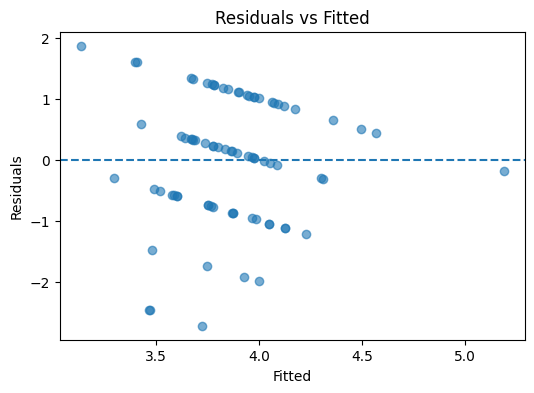

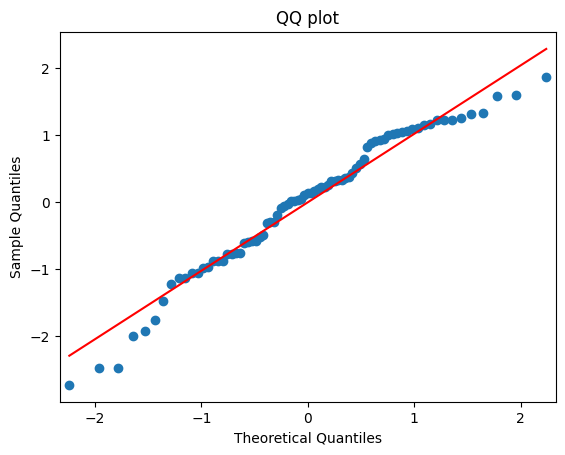

Breusch-Pagan: LM = 8.442, p = 0.0767; F = 2.214, p = 0.0757

VIFs (includes Intercept):


,variable,VIF
0,Intercept,19.074118
1,study_hours_per_week,1.047148
2,sleep_hours,1.099188
3,sleep_quality_1to10,1.085483
4,extracurricular_bin,1.024043


In [26]:
# Simple regression: stress ~ study_hours_per_week
if 'stress_1to5' in cleaned.columns and 'study_hours_per_week' in cleaned.columns:
    df_simp = cleaned[['stress_1to5','study_hours_per_week']].dropna()
    if len(df_simp) >= 3:
        model_simple = smf.ols('stress_1to5 ~ study_hours_per_week', data=df_simp).fit()
        print("Simple regression: stress ~ study_hours_per_week")
        print(model_simple.summary())
    else:
        print("Not enough rows for simple regression")

# Multiple regression: choose predictors automatically
possible_predictors = ['study_hours_per_week','courses_enrolled','job_hours_per_week','sleep_hours','sleep_quality_1to10','extracurricular_bin']
predictors = [p for p in possible_predictors if p in cleaned.columns]
if 'stress_1to5' in cleaned.columns and len(predictors) > 0:
    formula = 'stress_1to5 ~ ' + ' + '.join(predictors)
    df_multi = cleaned[['stress_1to5'] + predictors].dropna()
    print("\nTrying multiple regression with formula:", formula)
    if len(df_multi) > (len(predictors) + 1):
        model_multi = smf.ols(formula, data=df_multi).fit()
        print(model_multi.summary())
        # Residuals vs fitted
        resid = model_multi.resid
        fitted = model_multi.fittedvalues
        plt.figure(figsize=(6,4))
        plt.scatter(fitted, resid, alpha=0.6)
        plt.axhline(0, linestyle='--')
        plt.xlabel("Fitted"); plt.ylabel("Residuals"); plt.title("Residuals vs Fitted")
        plt.show()
        # QQ plot
        sm.qqplot(resid, line='s')
        plt.title("QQ plot")
        plt.show()
        # Heteroscedasticity test - Breusch-Pagan
        try:
            from statsmodels.stats.diagnostic import het_breuschpagan
            lm, lm_pvalue, fvalue, f_pvalue = het_breuschpagan(resid, model_multi.model.exog)
            print("Breusch-Pagan: LM = {:.3f}, p = {:.4f}; F = {:.3f}, p = {:.4f}".format(lm, lm_pvalue, fvalue, f_pvalue))
        except Exception as e:
            print("Breusch-Pagan test could not run:", e)
        # Multicollinearity - VIF
        try:
            X = model_multi.model.exog
            vif_df = pd.DataFrame()
            vif_df['variable'] = model_multi.model.exog_names
            vif_df['VIF'] = [variance_inflation_factor(X, i) for i in range(X.shape[1])]
            print("\nVIFs (includes Intercept):")
            display(vif_df)
        except Exception as e:
            print("VIF calculation failed:", e)
    else:
        print("Not enough rows for multiple regression (need rows > num_predictors+1).")
